In [31]:
import numpy as np
import pandas as pd
import random as rd
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
caracteristiques = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/e22ba475-45a3-46ac-a0f7-9ca9ed1e283a', sep=';').replace(-1, np.nan)
lieux = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/2ad65965-36a1-4452-9c08-61a6c874e3e6', sep=';').replace(-1, np.nan)
vehicules = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/780cd335-5048-4bd6-a841-105b44eb2667', sep=';').replace(-1, np.nan)
usagers = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/36b1b7b3-84b4-4901-9163-59ae8a9e3028', sep=';').replace(-1, np.nan)

On ajoute à `caracteristiques` une variable `mortel` qui indique si au moins un des usagers impliqués est décédé.

(Ce n'est pas forcément la mesure la plus pertinente de la gravité d'un accident mais c'est une première approche)

In [33]:
ids_accidents_mortels = usagers[usagers.grav == 2].Num_Acc.tolist()
caracteristiques['mortel'] = caracteristiques.Num_Acc.isin(ids_accidents_mortels)

In [34]:
accidents = caracteristiques.merge(lieux, on='Num_Acc')

In [49]:
# Fonction générique pour obtenir un histogramme indiquant le taux de mortalité en fonction d'une variable donnée
# (Pourra facilement être adaptée si un autre indicateur est choisi)
def taux_mortalite(var, xlabel, xlabels=None, na_values=[-1]):
    """Crée un histogramme affichant le taux d'accidents mortels pour au moins un usager selon la variable `var`.
    `xlabel` est le nom en français de la variable (pour la légende).
    `xlabels` est la liste des modalités, par ordre croissant (pour la légende).
    `na_values` indique la liste des valeurs (autre que `NaN`) indiquant une valeur manquante. Ces valeurs seront exclues de l'analyse."""

    # Création d'une base temporaire contenant uniquement les données pertinentes
    temp = accidents[~accidents[var].isin(na_values)]


    width = min(2*temp[var].nunique(), 15)
    fig, ax = plt.subplots(figsize=(width,7))
    sns.set_style('darkgrid')

    sns.barplot(data=temp, x=var, y='mortel', ax=ax, color='teal')

    # X axis
    plt.xlabel(xlabel.capitalize(), fontsize='large')
    locs, labels = plt.xticks()
    labels = xlabels if xlabels is not None else labels
    plt.xticks(locs, labels,
               rotation=0,
               horizontalalignment='center')
    
    # Y axis
    plt.ylabel("Taux d'accidents mortels", fontsize='large')
    locs, _ = plt.yticks()
    labels = [str(int(loc * 100)) + '%' for loc in locs]
    plt.yticks(locs, labels,
               rotation=0,
               horizontalalignment='right')

    plt.show()

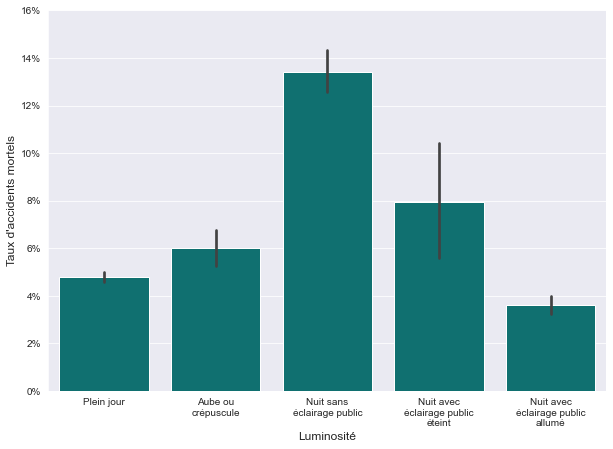

In [50]:
# Application à la variable `lum`
taux_mortalite('lum', 'Luminosité',
               xlabels=['Plein jour', 'Aube ou\ncrépuscule', 'Nuit sans\néclairage public', 'Nuit avec\néclairage public\néteint', 'Nuit avec\néclairage public\nallumé'])

Comme attendu, les accidents sont plus fréquemment mortels la nuit en l'absence d'éclairage.

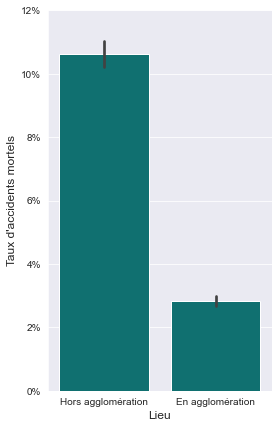

In [37]:
# Application à la variable `agg`
taux_mortalite('agg', 'Lieu', xlabels=['Hors agglomération', 'En agglomération'])

Encore une fois, résultat attendu : les accidents sont moins souvent mortels en agglomération compte tenu de la vitesse réduite des véhicules.

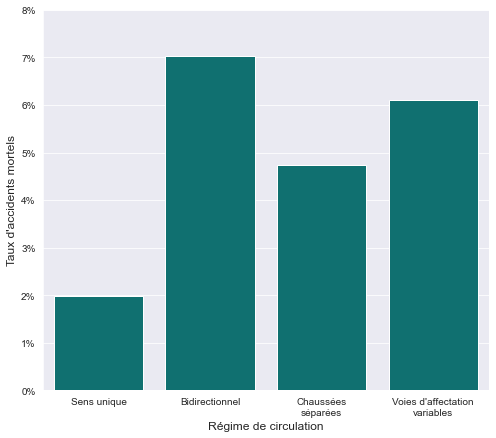

In [47]:
# Application à la varibale `circ`
taux_mortalite('circ', 'Régime de circulation', na_values=[-1],
               xlabels=['Sens unique', 'Bidirectionnel', 'Chaussées\nséparées', "Voies d'affectation\nvariables"])

Moins d'accidents mortels dans les rues à sens unique, probablement lié au fait que ce type de régime de circulation est plus fréquent en ville.

In [39]:
# Application à la variable `vma`
# Comme on n'a pas d'information sur l'interprétation des valeurs, on commence par les regarder
values = accidents[['vma', 'Num_Acc']].groupby(by='vma').count()
values.rename(columns={'Num_Acc': 'observations'}, inplace=True)
values.T

vma,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,10.0,12.0,...,90.0,100.0,110.0,120.0,130.0,500.0,560.0,600.0,700.0,800.0
observations,1,16,20,3,2,32,8,1,118,1,...,3436,9,2151,1,1166,15,1,1,1,1


-1 = non-renseigné ? Ca paraitrait logique puisque c'est le cas pour les autres variables

0 = aucun ? (idem)

Les valeurs 1 2, 3, 4, 6, 7, 12, 500, 600, 700, 800 sont probablement des erreurs de saisies (un 0 en trop ou en moins). Impossible à dire pour 5 et 10. Les prend-on en compte ? Pour le moment, je fais le graphe sans.

Les limitations à 42km/h et 560km/h n'existent pas donc ce sont probablement des erreurs aussi.

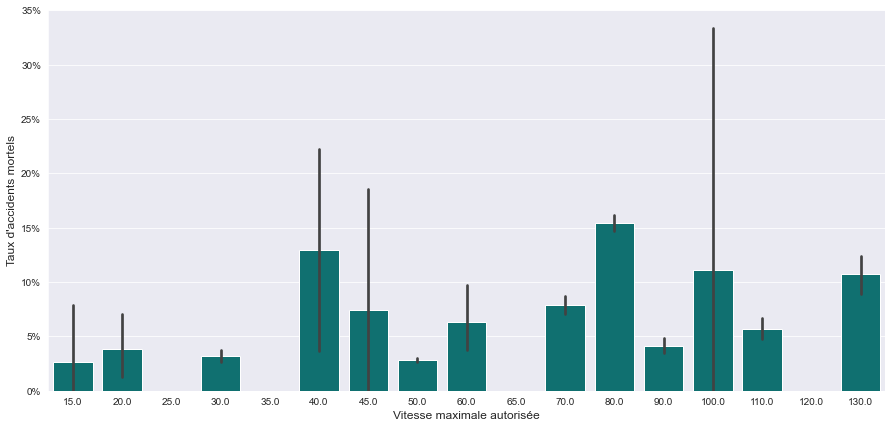

In [51]:
na_values = [-1,0,1,2,3,4,6,7,12,500,600,700,800,5,10,42,560]
taux_mortalite('vma', 'Vitesse maximale autorisée', na_values=na_values)

On voit à peu près une tendance croissante, avec des pics étranges à 40/45, 70/80 et 100.

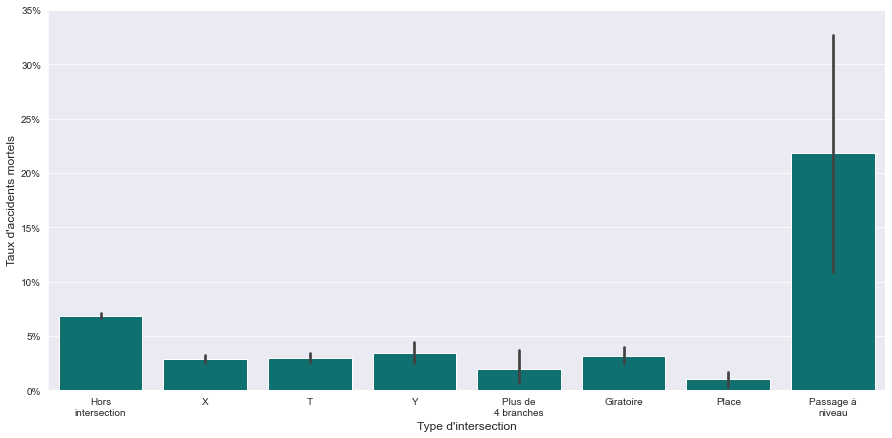

In [41]:
# Application au type d'intersection
taux_mortalite('int', "Type d'intersection", na_values=[9],
               xlabels=['Hors\nintersection', 'X', 'T', 'Y', 'Plus de\n4 branches', 'Giratoire', 'Place', 'Passage à\nniveau'])

Observation: plus d'accidents mortels sur les passages à niveau. <br>
Explication possible : violence des chocs avec un train plus importante.

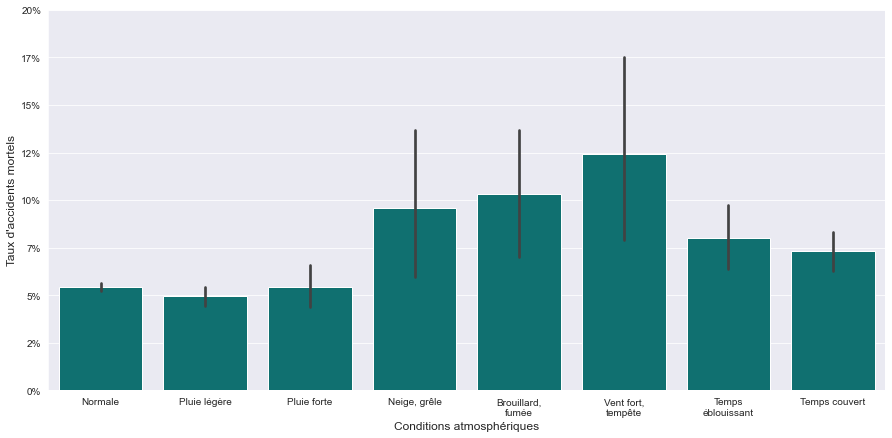

In [42]:
# Application à la variable `atm`
taux_mortalite('atm', 'Conditions atmosphériques', na_values=[-1,9],
               xlabels=['Normale', 'Pluie légère', 'Pluie forte', 'Neige, grêle', 'Brouillard,\nfumée', 'Vent fort,\ntempête', 'Temps\néblouissant', 'Temps couvert'])

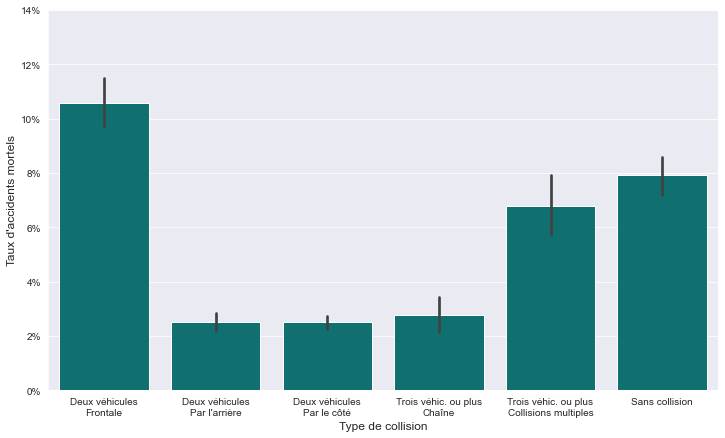

In [43]:
# Application à la variable `col`
taux_mortalite('col', 'Type de collision', na_values=[-1,6],
               xlabels=['Deux véhicules\nFrontale', 'Deux véhicules\nPar l\'arrière', 'Deux véhicules\nPar le côté', 'Trois véhic. ou plus\nChaîne', 'Trois véhic. ou plus\nCollisions multiples', 'Sans collision'])

Observation : chocs frontaux plus mortels. <br>
Explication possible : choc plus violent car différentiel de vitesse plus élevé. <br>

Peut également éclairer l'analyse du régime de circulation : les régimes bidirectionnel et avec affectation variable permettent les chocs frontaux, alors que ce n'est pas le cas pour le régime à sens unique.

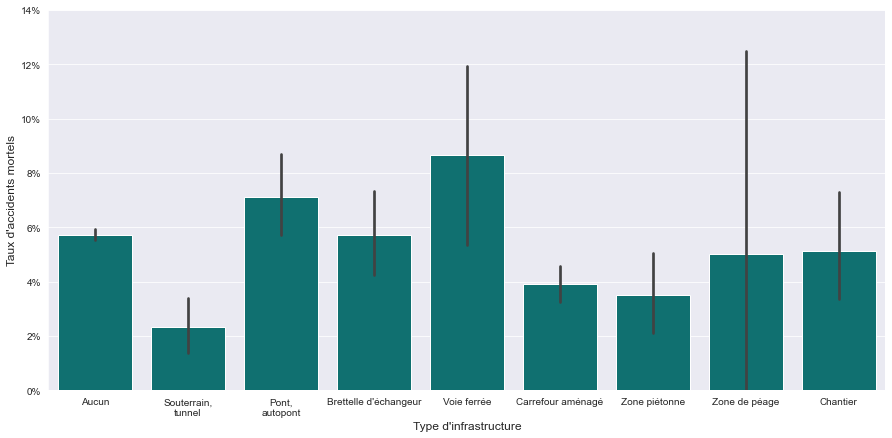

In [44]:
# Application à la variable `infra`
taux_mortalite('infra', "Type d'infrastructure", na_values=[-1,9],
               xlabels=['Aucun', 'Souterrain,\ntunnel', 'Pont,\nautopont', "Brettelle d'échangeur", 'Voie ferrée', 'Carrefour aménagé', 'Zone piétonne', 'Zone de péage', 'Chantier'])